In [4]:
import os
import cv2
import argparse
import numpy as np
import matplotlib.pyplot as plt
from imutils import paths
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.applications.resnet_v2 import ResNet101V2, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

  
import os
import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
import shutil

physical_devices = tf.config.list_physical_devices("GPU")
print("Num GPUs Available: ", physical_devices, len(tf.config.list_physical_devices('GPU')))
# tf.test.gpu_device_name()
device_lib.list_local_devices()

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)








Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')] 1
1 Physical GPUs, 1 Logical GPUs


In [2]:
import matplotlib.pyplot as plt
from tensorflow.keras import layers


initial_lr = 1e-3 # learning rate
epochs = 40 # no of eopches to train
batch_size = 32 # batch size 
img_size = 224

print("LOADING IMAGES.......")
imagePaths = list(paths.list_images("data"))
data = []
labels =[]


#loop for the image paths
for imagePath in imagePaths:
	#extract the class label from the file
	label = imagePath.split(os.path.sep)[-2]

	#load the image
	#swap color channels and resize it
	#fixed 224*224 pixels while ingorning aspect ratio
	image = cv2.imread(imagePath)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (img_size, img_size))

	#update the data and labes lists
	data.append(image)
	labels.append(label)

print("original labels: ", labels[0])
print("original labels: ", labels[-1])
# print("original labels to binary: ",labels)

#convert the data and labels to numpay
#while scalling the pixel to the range [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)


# performs one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

print("original labels to binary: ",labels[0])
print("original labels to binary: ",labels[-1])
# print("original labels to binary: ",labels)


#partition the data for tranning(80%)
#and testing(20%) using splits
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

data_generator_with_aug = ImageDataGenerator(
#  rotation_range=45,
#  fill_mode="nearest", 
#  horizontal_flip=True, 
 width_shift_range = 0.1, 
 height_shift_range = 0.1, 
#  shear_range=16
)


# data_generator_with_aug = ImageDataGenerator()




# print(testX)
# data_generator_with_aug.fit(trainX)
# print(plt.imshow(trainX[0]))
# print(lb.classes_)

LOADING IMAGES.......
original labels:  covideff
original labels:  normaleff
original labels to binary:  [0]
original labels to binary:  [1]


In [5]:

baseModel = ResNet101V2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(img_size, img_size, 3)))

baseModel.trainable=False  # all base weight set to non-trainable
#constructing the head of the model that will be placed
#on the top of the model
headModel = baseModel.output
headModel = layers.GlobalAveragePooling2D()(headModel)
# headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
# headModel = Dense(1, activation="sigmoid")(headModel)
headModel = Dense(1, activation="sigmoid")(headModel)
#place the head FC model on top of the base model
#it will become the actual model will be train
model = Model(inputs=baseModel.input, outputs=headModel)
# #loop over all layers in the base model 
# for layer in baseModel.layers:
# 	layer.trainable = False
#compile our model
print("compiling model.....")
opt = Adam(learning_rate=initial_lr, decay=initial_lr / epochs)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])


model.summary()



171319296/171317808 [==============================] - 24s 0us/step
compiling model.....
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
___

In [6]:
from tensorflow.keras.callbacks import ModelCheckpoint

summary_path = 'model_saved_new\\resnet\\'


model_filepath = summary_path + "model-Res101-{epoch:02d}-{val_accuracy:.4f}.h5"
checkpoint = ModelCheckpoint(
	filepath=model_filepath,
	monitor = 'val_accuracy',
	mode='max',
	save_best_only=True,
	verbose=1
)


#train the head of the network
print("tranning head.........")


history = model.fit(
	# x=trainX, y=trainY, batch_size= batch_size,
	data_generator_with_aug.flow(trainX, trainY, batch_size= batch_size),
	steps_per_epoch=len(trainX) // batch_size,
	validation_data = (testX, testY),
	validation_steps = len(testX) // batch_size,
	epochs = epochs,
	callbacks=[checkpoint]
	)




tranning head.........
Epoch 1/40
150/150 [==============================] - 48s 258ms/step - loss: 0.2630 - accuracy: 0.8896 - val_loss: 0.2008 - val_accuracy: 0.9233

Epoch 00001: val_accuracy improved from -inf to 0.92333, saving model to model_saved_new\resnet\model-Res101-01-0.9233.h5


c:\Users\User\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/40
150/150 [==============================] - 31s 209ms/step - loss: 0.2002 - accuracy: 0.9187 - val_loss: 0.1645 - val_accuracy: 0.9417

Epoch 00002: val_accuracy improved from 0.92333 to 0.94167, saving model to model_saved_new\resnet\model-Res101-02-0.9417.h5
Epoch 3/40
150/150 [==============================] - 31s 207ms/step - loss: 0.1809 - accuracy: 0.9277 - val_loss: 0.1720 - val_accuracy: 0.9342

Epoch 00003: val_accuracy did not improve from 0.94167
Epoch 4/40
150/150 [==============================] - 31s 206ms/step - loss: 0.1542 - accuracy: 0.9400 - val_loss: 0.1598 - val_accuracy: 0.9367

Epoch 00004: val_accuracy did not improve from 0.94167
Epoch 5/40
150/150 [==============================] - 31s 207ms/step - loss: 0.1468 - accuracy: 0.9429 - val_loss: 0.1723 - val_accuracy: 0.9292

Epoch 00005: val_accuracy did not improve from 0.94167
Epoch 6/40
150/150 [==============================] - 31s 207ms/step - loss: 0.1392 - accuracy: 0.9450 - val_loss: 0.1584 - va

In [7]:
import pandas as pd
import numpy as np

model_name =  'model-Res101-21-0.9542'

# print(testY.argmax(axis=1))
# print(testY)
np.save(summary_path +'testY_' + model_name + '.npy', testY)
np.save(summary_path +'trainY_' + model_name + '.npy', trainY)
np.save(summary_path +'testX_' + model_name + '.npy', testX)
np.save(summary_path +'trainX_' + model_name + '.npy', trainX)

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = summary_path +model_name + '_history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)
# or save to csv: 
hist_csv_file = summary_path +model_name + '_history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)



evaluating network.....
True positive =  571
True negative =  574
False positive =  26
False negative =  29
[[574  26]
 [ 29 571]]
accurancy: 0.9542
precision: 0.9567
sensitivity: 0.9519
specificity: 0.9564
f1-score: 0.9543
NPV: 0.9519


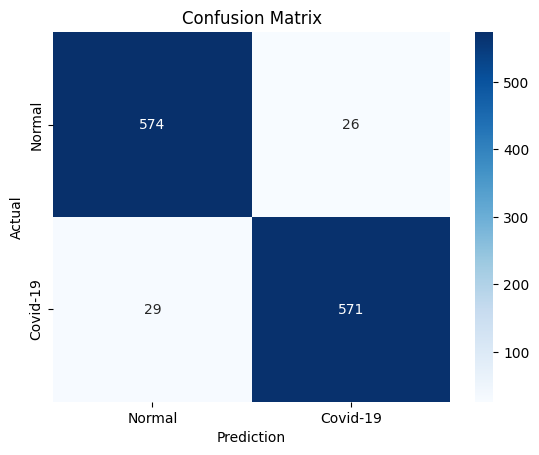

C:\Users\User\AppData\Local\Temp\ipykernel_26404\3136499845.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  history_df['epochs'][i]=int(history_df['epochs'][i])+1


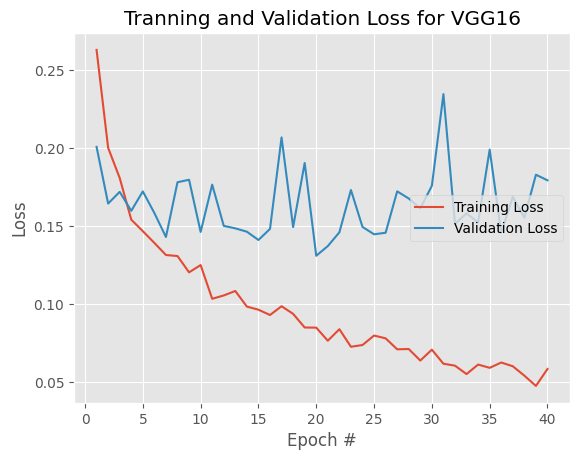

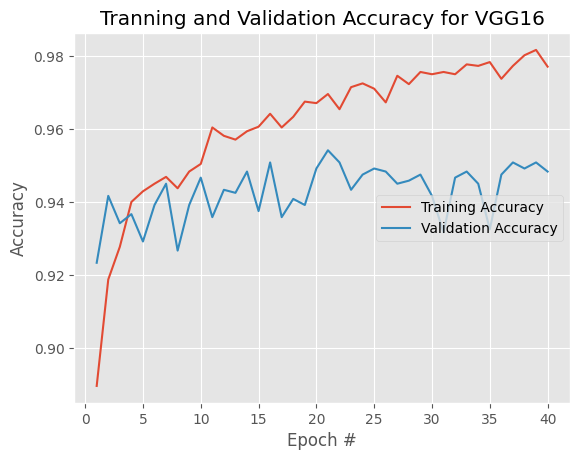

In [8]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Average
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

batch_size = 32

# result_path  = ''

summary_path = 'model_saved_new\\resnet\\'

# result_path use this to store different condition
result_path  = ''
model_name = 'model-Res101-21-0.9542'

# testX_data =testX
# testY_data =testY
testY_data = np.load(summary_path +result_path + 'testY_' + model_name + '.npy')
trainY_data = np.load(summary_path +result_path + 'trainY_' + model_name + '.npy')
testX_data = np.load(summary_path +result_path + 'testX_' + model_name + '.npy')
trainX_data = np.load(summary_path +result_path + 'trainX_' + model_name + '.npy')

# # convert the history.history dict to a pandas DataFrame:     
# hist_df = pd.DataFrame(history.history) 



model = load_model(summary_path +result_path + model_name + '.h5')
# make predications on the testing set
print("evaluating network.....")
predIdxs = model.predict(testX_data, batch_size=batch_size)

threshold = 0.5

# Convert predicted probabilities to binary values using threshold
predIdxs = (predIdxs > threshold).astype(int)

# print(predIdxs)
# print(testY_data)
# for each image in the testing set we need 
# to find the the index of the label with 
# corresponding largest predicated probability

# predIdxs = np.argmax(predIdxs, axis=1)
# testY original is [1. 0.] testY.argmax(axis=1) let 
# [1. 0.] become 0
# [0. 1.] become 1

# import pandas as pd
# # convert the history.history dict to a pandas DataFrame:     
# hist_df = pd.DataFrame(history.history) 

# # save to json:  
# hist_json_file = model_name + '_history.json' 
# with open(hist_json_file, mode='w') as f:
#     hist_df.to_json(f)

# # or save to csv: 
# hist_csv_file = model_name + '_history.csv'
# with open(hist_csv_file, mode='w') as f:
#     hist_df.to_csv(f)

# show a nicely formatted classification report

# print(classification_report(testY.argmax(axis=1), predIdxs,
# 	target_names=lb.classes_))

### lb.classes_ = covideff normaleff


#### for confusion matrix
# compute the confusion matrix nad use it 
# to drive the raw accuracy, sensitivity 
# and specificity
# cm = confusion_matrix(testY_data.argmax(axis=1), predIdxs)

cm = confusion_matrix(testY_data, predIdxs)

tp = cm[1,1]
tn = cm[0,0]
fp = cm[0,1]
fn = cm[1,0]

print('True positive = ', tp)
print('True negative = ', tn)
print('False positive = ', fp)
print('False negative = ', fn)

total_test = sum(sum(cm))
accurancy = (cm[0, 0] + cm[1, 1]) / total_test	### Accuracy (all correct / all) = TP + TN / TP + TN + FP + FN
precision = cm[0, 0] / (cm[0, 0] + cm[0, 1])
sensitivity = cm[0, 0] / (cm[0, 0] + cm[1, 0])	### Sensitivity aka Recall (true positives / all actual positives) = TP / TP + FN
specificity = cm[1, 1] / (cm[1, 1] + cm[0, 1])	### Specificity (true negatives / all actual negatives) =TN / TN + FP
f1score = 2*(precision*sensitivity)/(precision+sensitivity)
npv = tn/(tn+fn)

# show the cnfusion matrix, accuracy with 4 digits
#sensitivity, and specificity
print(cm)
print("accurancy: {:.4f}".format(accurancy))
print("precision: {:.4f}".format(precision))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))
print("f1-score: {:.4f}".format(f1score))
print("NPV: {:.4f}".format(npv))


import seaborn as sns
### fmt ='g' to turn off scientific number 
sns.heatmap(cm, cmap="Blues",annot=True, fmt='g',xticklabels=["Normal", "Covid-19"], yticklabels=["Normal", "Covid-19"])
plt.title("Confusion Matrix")
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.show()


#### for loss and accuracy curve
import matplotlib.pyplot as plt
import json
import pandas as pd

model_history_json_name = summary_path +  result_path + model_name + '_history.json'
history_json = json.load(open(model_history_json_name, 'r'))
history_df=pd.DataFrame(history_json)
history_df=history_df.reset_index()
history_df.columns.values[0]='epochs'


for i in range(len(history_df['epochs'])):
    history_df['epochs'][i]=int(history_df['epochs'][i])+1


def annot_max(x,y, ax=None):
    maxIxVal = np.argmax(y);
    zeroBasedIx = np.argwhere(y.index==maxIxVal).flatten()[0];
    xmax = x[zeroBasedIx];
    ymax = y.max()
    text= "k={:d}, measure={:.3f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="round,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="-",connectionstyle="arc3,rad=0.1")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.90), **kw)

def annot_min(x,y, ax=None):
    minIxVal = np.argmin(y);
    zeroBasedIx = np.argwhere(y.index==minIxVal).flatten()[0];
    xmin = x[zeroBasedIx];
    ymin = y.min()
    text= "k={:d}, measure={:.3f}".format(xmin, ymin)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="round,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="-",connectionstyle="arc3,rad=0.1")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmin, ymin), xytext=(0.94,0.90), **kw)


plt.style.use("ggplot")
plt.figure()
plt.plot()
plt.plot(history_df['epochs'],history_df['loss'],label='Training Loss')
plt.plot(history_df['epochs'],history_df['val_loss'],label='Validation Loss')
plt.legend(loc="center right")
plt.title("Tranning and Validation Loss for VGG16")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
# annot_max(history_df['epochs'],history_df['loss'])
plt.show()

plt.figure()
plt.plot()
plt.plot(history_df['epochs'],history_df['accuracy'],label='Training Accuracy')
plt.plot(history_df['epochs'],history_df['val_accuracy'],label='Validation Accuracy')
plt.legend(loc="center right")
plt.title("Tranning and Validation Accuracy for VGG16")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
# annot_max(history_df['epochs'],history_df['accuracy'])
# annot_max(history_df['epochs'],history_df['val_accuracy'])
plt.show()



#fn here: actual is 0(covideff) but identify to 1(normalleff) 0-->1: 7 0-->0:73
# for current confusion matrix become:
# original labels:  covideff
# original labels:  normaleff
# original labels to binary:  [0]
# original labels to binary:  [1]
# binary labels to category:  [1. 0.]
# binary labels to category:  [0. 1.]
# normaleff:	tn fp
# covideff:	fn tp


## confusion matrix (normally online is like below, my diff with online)
## tp fp
## fn tn

### Accuracy (all correct / all) = TP + TN / TP + TN + FP + FN
### Misclassification (all incorrect / all) = FP + FN / TP + TN + FP + FN
### Precision (true positives / predicted positives) = TP / TP + FP
### Sensitivity aka Recall (true positives / all actual positives) = TP / TP + FN
### Specificity (true negatives / all actual negatives) =TN / TN + FP


